A discrete controller class
---------------------------

Let's extend the example from our previous object-oriented simulation notebook to discrete controllers.

In [1]:
import numpy
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

We start by defining a `class` for the tank system again:

In [2]:
class TankSystem:
    def __init__(self, A, alpha, K, V, Fi):
        """ This special function gets called when an object of this class is created"""
        self.A = A
        self.alpha = alpha
        self.K = K
        self.Fi = Fi
        self.change_state(V)
    
    def f(self, x):
        return self.alpha**(x - 1)
    
    def change_input(self, x):
        self.Fo = self.K*self.f(x)*numpy.sqrt(self.h)
        
    def change_state(self, V):
        self.state = self.V = V
        self.output = self.h = self.V/self.A

    def derivative(self, x):
        self.change_input(x)
        dVdt = self.Fi - self.Fo
        return dVdt

But this time we'll do a discrete controller:

In [3]:
class DiscreteController:
    def __init__(self, DeltaT, Kc, tau_i, bias):
        self.DeltaT = DeltaT
        self.Kc = Kc
        self.tau_i = tau_i
        self.next_sample_time = 0
        self.error_sum = 0
        self.bias = self.output = bias
        
    def update(self, u, t):
        if t >= self.next_sample_time:
            self.error_sum += u
            self.output = self.Kc*(u + 1/self.tau_i*self.error_sum)
            self.next_sample_time += self.DeltaT

I've changed the way we update the controller here to accomodate the fact that discrete controllers don't have states to integrate, so we don't need the `derivative` method. The way I've built this class requires that the `update` method be called with strictly ascending times in `t`. Note that this class corresponds very closely to a physical box. All the sampling is taking place inside the class and it is designed to be updated in a "normal" Euler integration loop. See how using classes makes the calculations which are about a particular physical object (the controller) stay together in the code rather than being spread out in lots of places?

Of course, we still have to test that this works:

In [4]:
ts = numpy.linspace(0, 100, 1000)
dt = ts[1]

In [5]:
sp = 1.3

I've changed this function to use the new `update` methods, but otherwise it is similar to the previous one.

In [6]:
def control_simulation_discrete(system, controller):
    outputs = []
    for t in ts:
        system.change_input(controller.output)

        e = sp - system.output

        controller.update(e, t)

        system.change_state(system.state + system.derivative(controller.output)*dt)

        outputs.append(system.output)
    return outputs

In [7]:
system = TankSystem(A=2, alpha=20, K=2, V=2, Fi=1)
controller = DiscreteController(DeltaT=1, Kc=-1, tau_i=5, bias=0.7)

In [8]:
outputs = control_simulation_discrete(system, controller)

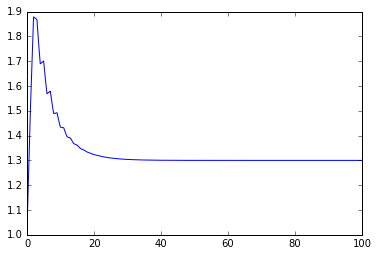

In [9]:
plt.plot(ts, outputs)

We can still simulate different situations easily.

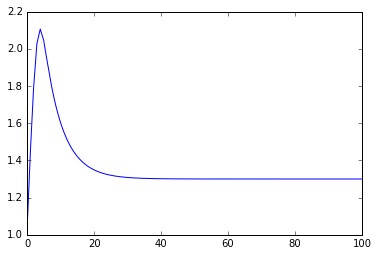

In [10]:
outputs = control_simulation_discrete(system=TankSystem(A=2, alpha=10, K=2, V=2, Fi=1), 
                                      controller=DiscreteController(DeltaT=1, Kc=-0.5, tau_i=5, bias=0.5))
plt.plot(ts, outputs);